In [1]:
import pandas as pd
from collections import Counter
# import geopandas as gpd
import numpy as np

# Add aggregated demographic data to the shapefile of wards

In [3]:
SURVEY_LOCATION='../../Data/Bản sao của data HIDS.xlsx'

In [4]:
householders=pd.read_excel(SURVEY_LOCATION, sheet_name='Form_01(Householdhead)', header=3)
all_members=pd.read_excel(SURVEY_LOCATION, sheet_name='Form_02（ALLmember）', header=3)
# range_hh=pd.read_excel(SURVEY_LOCATION, sheet_name='Range(HouseholdHead)')
# range_member=pd.read_excel(SURVEY_LOCATION, sheet_name='Range(AllMember)')

In [5]:
# for q in range_hh['Question']:
#     print(q)

Drop the first row under the header row

In [6]:
householders=householders.drop(0, axis=0)
all_members=all_members.drop(0, axis=0)

In [7]:
rename_cols_hh={'Q14.Tổng thu nhập hàng tháng của hộ gia đình là bao nhiêu (VNĐ/tháng)?': 'hh_income',
                'Q4.Địa chỉ nhà': 'home_address'}
rename_cols_all={'Q29.Chỉ những người thuộc từ mục 1-10 của câu 28 mới trả lời, Lĩnh vực nghê nghiệp': 'career',
                 'Q33.Chỉ những người thuộc từ mục 1-12 của Q28 (nghĩa là đang đi học hoặc đi làm) thì mới trả lời, Địa chỉ nơi làm việc/ trường học?': 'work_school_address'}

In [8]:
householders=householders.rename(columns=rename_cols_hh)
all_members=all_members.rename(columns=rename_cols_all)

In [ ]:
# income_group_totals=Counter(householders['hh_income'])
# income_group_totals_ordered=[income_group_totals[float(i)] for i in range(1, 16)]
# np.cumsum(income_group_totals_ordered)

### Create dummys for the income and field columns

In [9]:
income_dummys=pd.get_dummies(householders['hh_income'].astype('Int64'), prefix='income')
career_dummys=pd.get_dummies(all_members['career'].astype('Int64'), prefix='career')

Make the income categories roughly evenly sized

In [10]:
by_income_totals=income_dummys.sum()

In [11]:
import numpy as np
np.cumsum(by_income_totals)/sum(by_income_totals)

income_1     0.00440
income_2     0.00485
income_3     0.00540
income_4     0.00705
income_5     0.01140
income_6     0.03450
income_7     0.12490
income_8     0.28920
income_9     0.49750
income_10    0.76340
income_11    0.90520
income_12    0.96035
income_13    0.98255
income_14    0.99445
income_15    1.00000
dtype: float64

Income groups 1 to 8 are roughly the bottom quartile <br>
Income groups 9 and 10 are 2nd and 3rd quartiles. <br>
Income groups 11 to 15 are the top quartile <br>

In [12]:
def get_income_quantiles(row):
    if row['hh_income']<9:
        row['res_income_1']=1
    elif row['hh_income']==9:
        row['res_income_2']=1
    elif row['hh_income']==10:
        row['res_income_3']=1
    else:
        row['res_income_4']=1
    return row

In [13]:
for i in range(1,5):
    householders['res_income_{}'.format(i)]=0
householders=householders.apply(lambda row: get_income_quantiles(row), axis=1)

In [14]:
res_income_cols=['res_income_{}'.format(i) for i in range(1,5)]
for col in res_income_cols:
    print(householders[col].sum()/len(householders))

0.2892
0.2083
0.2659
0.2366


In [15]:
for col in career_dummys.columns:
    all_members[col]=career_dummys[col]

## Perform Aggregations

In [16]:
by_home_area_income=householders.groupby('home_address')[res_income_cols].sum()

In [17]:
by_home_area_income

,res_income_1,res_income_2,res_income_3,res_income_4
home_address,,,,
1,19,12,13,15
2,2,5,12,21
3,3,2,2,3
4,3,2,2,3
5,2,1,0,7
...,...,...,...,...
258,65,33,42,18
263,16,14,16,40
264,65,47,40,17


In [18]:
# by_work_area_field=all_members.groupby(['work_school_address', 'career']).size()
by_work_area_field=all_members.groupby('work_school_address')[career_dummys.columns].sum()

In [19]:
by_work_area_field

,career_1,career_2,career_3,career_4,career_5,career_6,career_7,career_8,career_9,career_10
work_school_address,,,,,,,,,,
1,5.0,10.0,12.0,19.0,5.0,12.0,16.0,12.0,9.0,55.0
2,2.0,23.0,16.0,56.0,11.0,20.0,35.0,10.0,15.0,65.0
3,1.0,11.0,20.0,46.0,15.0,43.0,34.0,8.0,19.0,99.0
4,2.0,17.0,5.0,47.0,7.0,25.0,22.0,3.0,12.0,58.0
5,0.0,12.0,9.0,28.0,6.0,17.0,19.0,2.0,9.0,62.0
...,...,...,...,...,...,...,...,...,...,...
292,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### TODO: need number of people resident in each ward, not number of households. For now, just use a simple scaling factor for adults per household.

In [20]:
adults_per_hh=by_work_area_field.sum().sum()/by_home_area_income.sum().sum()
adults_per_hh

1.7914

In [21]:
by_home_area_income*=adults_per_hh

### Scale up survey data to actual population

In [13]:
by_home_area_income*=100
by_work_area_field*=100

### Map to NAICS codes: https://www.naics.com/search/
- TODO: revisit these with more precision. eg. career 6 seems to include retail as well as accommodation/food. career 10 should be a mix of multiple categories.'

In [22]:
field_to_naics={'career_1': 'emp_naics_11',
                'career_2': 'emp_naics_21',
                'career_3': 'emp_naics_23',
                'career_4': 'emp_naics_72',
                'career_5': 'emp_naics_92',
                'career_6': 'emp_naics_48-49',
                'career_7': 'emp_naics_52',
                'career_8': 'emp_naics_61',
                'career_9': 'emp_naics_62',
                'career_10': 'emp_naics_81'
               }

In [23]:
by_work_area_field=by_work_area_field.rename(columns=field_to_naics)
by_work_area_field

,emp_naics_11,emp_naics_21,emp_naics_23,emp_naics_72,emp_naics_92,emp_naics_48-49,emp_naics_52,emp_naics_61,emp_naics_62,emp_naics_81
work_school_address,,,,,,,,,,
1,5.0,10.0,12.0,19.0,5.0,12.0,16.0,12.0,9.0,55.0
2,2.0,23.0,16.0,56.0,11.0,20.0,35.0,10.0,15.0,65.0
3,1.0,11.0,20.0,46.0,15.0,43.0,34.0,8.0,19.0,99.0
4,2.0,17.0,5.0,47.0,7.0,25.0,22.0,3.0,12.0,58.0
5,0.0,12.0,9.0,28.0,6.0,17.0,19.0,2.0,9.0,62.0
...,...,...,...,...,...,...,...,...,...,...
292,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Calculate Totals

In [24]:
by_home_area_income['res_total']=by_home_area_income.sum(axis=1)
by_work_area_field['emp_total']=by_work_area_field.sum(axis=1)

In [14]:
by_home_area_income.to_csv('../outputs/by_home_area_income.csv')
by_work_area_field.to_csv('../outputs/by_work_area_field.csv')

## Join attributes to shape file

In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
by_home_area_income=pd.read_csv('../outputs/by_home_area_income.csv', index_col=0)
by_work_area_field=pd.read_csv('../outputs/by_work_area_field.csv', index_col=0)

In [3]:
population=gpd.read_file('../Data/GIS/Population/population_HCMC/population_shapefile/Population_Ward_Level.shp')

### Convert the Ward codes to be consistent with the shapefile using the mapping

In [4]:
code_mapping_df=pd.read_csv('../Data/GIS/Survey/ward_code_mapping.csv')

In [5]:
code_mapping_df.groupby('Com_ID').size().sort_values(ascending=False)

Com_ID
26740    3
27139    2
27427    2
27433    2
26758    2
        ..
27031    1
27037    1
27043    1
27049    1
28168    1
Length: 243, dtype: int64

Some survey codes map to the same ward code

In [6]:
code_mapping={row['Code_Zone']: row['Com_ID'] for ind, row in code_mapping_df.iterrows()}

In [7]:
by_home_area_income['GEOID']=[str(code_mapping[i]) if i in code_mapping else -1 for i in by_home_area_income.index]
by_work_area_field['GEOID']=[str(code_mapping[i]) if i in code_mapping else -1 for i in by_work_area_field.index]

Aggregate the ones with the same ward code

In [8]:
by_home_geoid_income=by_home_area_income.groupby('GEOID').sum()
by_work_geoid_field=by_work_area_field.groupby('GEOID').sum()

In [9]:
by_home_geoid_income=by_home_geoid_income.drop(-1)
by_work_geoid_field=by_work_geoid_field.drop(-1)

In [10]:
by_home_geoid_income

,res_income_1,res_income_2,res_income_3,res_income_4,res_total
GEOID,,,,,
25741,8777.86,3403.66,4120.22,2328.82,18630.56
25744,15226.90,6986.46,8777.86,6269.90,37261.12
25759,2149.68,3045.38,2149.68,1612.26,8957.00
25765,9494.42,3403.66,3761.94,1970.54,18630.56
25942,27229.28,24542.18,19705.40,8777.86,80254.72
...,...,...,...,...,...
28027,6807.32,1612.26,179.14,358.28,8957.00
28111,15047.76,5195.06,5374.20,1253.98,26871.00
28159,8419.58,4120.22,4478.50,2328.82,19347.12


In [11]:
population['GEOID']=population['Com_ID'].astype(str)

In [12]:
population=population.set_index('GEOID')

In [13]:
zones=population.merge(by_home_geoid_income, left_index=True, right_index=True, how='left')

In [14]:
zones=zones.merge(by_work_geoid_field, left_index=True, right_index=True, how='left')

In [15]:
centroids=zones['geometry'].centroid
zones['x_centroid']=[c.x for c in centroids]
zones['y_centroid']=[c.y for c in centroids]

In [16]:
zones['sim_area']=zones['Dist_Name']=='District 4'
zones['model_area']=True
zones['reference_area']=zones['Dist_Name']=='District 4'

In [17]:
zones=zones.rename(columns={'Shape_Area': 'area'})

In [18]:
zones=zones.to_crs('EPSG:4326')

<AxesSubplot:>

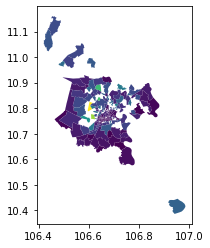

In [19]:
zones.plot(column='res_total')

### TODO: estimate the attributes of the areas with no data

In [161]:
zones.to_file('../outputs/zones.geojson', driver='GeoJSON')

In [21]:
zones.columns

Index(['Com_Name', 'Dist_Name', 'Com_ID', 'Dist_ID', 'Level', 'Pop_2009',
       'Pop_2019', 'Den_2009', 'Den_2019', 'Shape_Leng', 'area', 'geometry',
       'res_income_1', 'res_income_2', 'res_income_3', 'res_income_4',
       'res_total', 'emp_naics_11', 'emp_naics_21', 'emp_naics_23',
       'emp_naics_72', 'emp_naics_92', 'emp_naics_48-49', 'emp_naics_52',
       'emp_naics_61', 'emp_naics_62', 'emp_naics_81', 'emp_total',
       'x_centroid', 'y_centroid', 'sim_area', 'model_area', 'reference_area'],
      dtype='object')

# Create the simulated population file

In [20]:
od=gpd.read_file('../Data/GIS/OD_2014/OD_Shapefile/2014_HIDS_OD_Matrix.shp')

In [22]:
income_cols=[col for col in zones.columns if 'res_income' in col]
naics_cols=[col for col in zones.columns if 'emp_naics' in col]

In [25]:
row

Start_Code                                                26734
End_Code                                                  27274
NumberFlow                                                    3
Start_Ward                                        Tan Dinh Ward
End_Ward                                                 Ward 5
Start_Dist                                           District 1
End_Dist                                             District 4
Start_City                                     Ho Chi Minh City
End_City                                       Ho Chi Minh City
Shape_Len                                           3782.846933
geometry      LINESTRING (684843.8518000003 1193564.16850000...
Name: 0, dtype: object

In [35]:
row['NumberFlow']

3

In [36]:
import numpy as np
simpop=[]
for ind, row in od.iterrows():
    if ((str(row['Start_Code']) in zones.index) and (str(row['End_Code']) in zones.index)):
        sampled_income_cols=np.random.choice(income_cols, row['NumberFlow'],
            p=[zones.loc[str(row['Start_Code']), col]/zones.loc[str(row['Start_Code']), 'res_total'] for col in income_cols])

        sampled_naics_cols=np.random.choice(naics_cols, row['NumberFlow'],
            p=[zones.loc[str(row['End_Code']), col]/zones.loc[str(row['End_Code']), 'emp_total'] for col in naics_cols])

        for i in range(row['NumberFlow']):
            income=sampled_income_cols[i].split('res_income_')[1]

            naics=sampled_naics_cols[i].split('emp_naics_')[1]

            simpop.append({'home_geoid': str(row['Start_Code']),
                          'work_geoid': str(row['End_Code']),
                          'earnings': income,
                          'naics': naics})
simpop_df=pd.DataFrame(simpop)
simpop_df

,home_geoid,work_geoid,earnings,naics
0,26734,27274,2,81
1,26734,27274,2,21
2,26734,27274,1,81
3,26734,27265,4,48-49
4,26734,27265,1,81
...,...,...,...,...
5170,27499,27277,3,81
5171,27664,27262,1,81
5172,27664,27256,1,62
5173,27664,27259,1,48-49


In [37]:
simpop_df.to_csv('../outputs/simpop.csv', index=False)